In [1]:
# simmulate sounds in a grid of parameter values
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg
import socket
import os
import sys
import logging
import h5py

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

if 'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/repos/')
    experiment_folder = os.path.join('/Users/zeke/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'swissknife'))

#setup the data folder
from h5tools import h5tools
from h5tools import tables
from dynamo import finch as zf
from dynamo import takens as tk
from bci import expstruct as es

def sim_and_store(sim_pars, h5_file):
    sweep_group = h5_file.require_group(sim_pars['sweep_name'])
    h5tools.dict_2_group(sweep_group, sim_pars['vocal_pars'], 'vocal_pars')
    synth_group = sweep_group.require_group('synth')
    # create the group for the gamma
    gamma_group = synth_group.require_group('{0:5d}'.format(sim_pars['gamma']))
    sweep_table = tables.unlimited_rows_data(gamma_group, 'alpha_beta', 
                                             np.array([sim_pars['alpha'], 
                                                       sim_pars['beta']]).reshape([1,2]))
                                            
    
    alpha_values = sim_pars['alpha'] * np.ones(sim_pars['sim_samples'])
    beta_values = sim_pars['beta'] * np.ones(sim_pars['sim_samples'])
    env_values = np.ones(sim_pars['sim_samples'])
    par_stream = np.array([alpha_values, beta_values, env_values]).T
    for key in ['alpha', 'beta', 'gamma', 's_f', 'steps_per_sample']:
        vocal_pars['sys'][key] = sim_pars[key]
    song_synth = zf.finch(vocal_pars, par_stream, x_0=sim_pars['x_0'])
    pin_table = tables.unlimited_rows_data(gamma_group, 'pre_in', 
                                           song_synth[:,1].reshape([1,-1]))
    pout_table = tables.unlimited_rows_data(gamma_group, 'pre_out', 
                                            song_synth[:,0].reshape([1,-1]))

INFO:root:Computer: lookfar
2016-10-13 01:42:57,502 root         INFO     Computer: lookfar


In [2]:
sys_pars = {'alpha_1': 0.15,
            'beta_1': 0.15,
            'alpha_2': 0.15,
            'beta_2': 0.15,
            'gamma': 23500.,
            'Ch_inv': 4.5E10,
            'Lb_inv': 1.E-4,
            'Lg_inv': 1/82.,
            'Rb': 5E6,
            'Rh': 6E5,
            'V_ext': 0.,
            'dV_ext': 0.,
            'noise': 0.,
            'envelope': 0.,
            'noise_fraction_beta_1': 0.1,
            'noise_fraction_env': 0.1,
            's_f': 44100.,
            'steps_per_sample': 20
            }

vocal_pars = {'sys': sys_pars,
              'S_1': 0.2,
              'S_2': 0.2,
              'S_3': 0.2,
              'l_1': 1.5,
              'l_2': 1.5,
              'l_3': 1.0,
              'r_out': 0.1,
              'r_12': None,
              'r_21': None,
              'r_23': None,
              'r_32': None,
              't_12': None,
              't_21': None,
              't_23': None,
              't_32': None,
              't_in': 0.5,
              'tau_1': None,
              'tau_2': None,
              'tau_3': None,
              'max_tau': None,
              'A_1': 0.,
              'A_2': None,
              'A_3': None}

In [5]:
sweep_name = 'sweep_000'
sweep_file_path = os.path.join(es.file_names('')['folders']['tmp'], 'syn_sweeps', 'finch_00.h5')

sim_pars = {'sweep_name' : sweep_name,
            'gamma': 23500,
            'alpha': 0.,
            'beta': 0.,
            'vocal_pars': vocal_pars,
            'sim_samples': 4410,
            's_f': 44100.,
            'steps_per_sample': 20,
            'x_0': np.array([5.E-12, 1.E-11, 1.E-12, 1.E-11, 1.E-12])
           }

def sweep(ab_list, sim_pars, h5_path, mode='x'):
    es.mkdir_p(os.path.split(h5_path)[0])
    logger.info('Sweeping {0} values of alpha, beta with g={1} to file {2}'.format(
            ab_list.shape[0], sim_pars['gamma'], h5_path))
    try:
        with h5py.File(h5_path, mode) as f:
            for sim_pars['alpha'], sim_pars['beta'] in np.nditer([ab_list[:,0], ab_list[:,1]]):
                logger.debug('Simulating with {0}, {1}'.format(sim_pars['alpha'],
                                                              sim_pars['beta']))
                sim_and_store(sim_pars, f)
        logger.info('Sweep done successfully')
    except UnboundLocalError, err:
        last_err = err
        logger.error(err)
    

par_list = np.array([np.linspace(-.15, -.3, 4), np.linspace(0, -.5, 4)]).T
sweep(par_list, sim_pars, sweep_file_path, mode='a')

DEBUG:expstruct:Creating directory /Users/zeke/bci_zf/tmp_data/syn_sweeps
2016-10-07 15:40:02,319 expstruct    DEBUG    Creating directory /Users/zeke/bci_zf/tmp_data/syn_sweeps
DEBUG:expstruct:Directory existed, doing nothing
2016-10-07 15:40:02,321 expstruct    DEBUG    Directory existed, doing nothing
INFO:root:Sweeping 4 values of alpha, beta with g=23500 to file /Users/zeke/bci_zf/tmp_data/syn_sweeps/finch_00.h5
2016-10-07 15:40:02,321 root         INFO     Sweeping 4 values of alpha, beta with g=23500 to file /Users/zeke/bci_zf/tmp_data/syn_sweeps/finch_00.h5
DEBUG:root:Simulating with -0.15, 0.0
2016-10-07 15:40:02,322 root         DEBUG    Simulating with -0.15, 0.0
DEBUG:h5tools:Translating dictionary key vocal_pars into its own group
2016-10-07 15:40:02,323 h5tools      DEBUG    Translating dictionary key vocal_pars into its own group
DEBUG:h5tools:Unable to create group (Name already exists)
2016-10-07 15:40:02,324 h5tools      DEBUG    Unable to create group (Name already e

In [23]:
sweep_name = 'sweep_000'
sim_pars = {'sweep_name' : sweep_name,
            'gamma': 23500,
            'alpha': 0.,
            'beta': 0.,
            'vocal_pars': vocal_pars,
            'sim_samples': 4410,
            's_f': 44100.,
            'steps_per_sample': 20,
            'x': np.array([5.E-12, 1.E-11, 1.E-12, 1.E-11, 1.E-12])
           }

In [11]:
es.mkdir_p(os.path.join(es.file_names('')['folders']['tmp'], 'syn_sweeps', 'finch_01.h5'))

DEBUG:expstruct:Creating directory /Users/zeke/bci_zf/tmp_data/syn_sweeps/finch_01.h5
2016-10-07 15:30:39,803 expstruct    DEBUG    Creating directory /Users/zeke/bci_zf/tmp_data/syn_sweeps/finch_01.h5
DEBUG:expstruct:Directory existed, doing nothing
2016-10-07 15:30:39,804 expstruct    DEBUG    Directory existed, doing nothing


In [6]:
import h5py

In [6]:
es.file_names('')['folders']

{'kai': '/mnt/cube/kai/results/',
 'prb': '/Volumes/gentner/earneodo/bci_zf/probes',
 'raw': '/Users/zeke/bci_zf/raw_data/',
 'rw': '/Volumes/gentner/earneodo/bci_zf/raw_data/',
 'ss': '/Volumes/gentner/earneodo/bci_zf/ss_data/',
 'stim': '/Volumes/gentner/earneodo/bci_zf/stim_data/',
 'templ': '/Volumes/gentner/earneodo/bci_zf/templates',
 'tmp': '/Users/zeke/bci_zf/tmp_data/'}

In [5]:
reload(es)

<module 'bci.expstruct' from '/Users/zeke/repos/swissknife/bci/expstruct.py'>

In [8]:
f = h5py.File('parallel_test.hdf5', 'w', driver='mpio')


NameError: global name 'mpi4py' is not defined

319


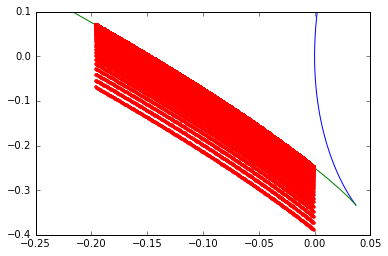

In [3]:
ab_g= tk.cusp_grid()
lines = tk.cusp_lines(b_max=0.07, b_min=-1 / 3, a_step=1E-3, b_steps=100, b_log_step_exp=5, f_max=None)
plt.plot(lines[:,1], lines[:,0])
plt.plot(lines[:,2], lines[:,0])
plt.plot(ab_g[:,0], ab_g[:,1], '.')


In [5]:
ab_g.shape

(31900, 2)